Cassava Leaf Disease Classification - Data Augmentation

Imports

In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import pytorch_lightning as pl
from torch.nn import functional as F
from collections import defaultdict
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import models
import torch.nn as nn
import os
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
from torchvision import transforms
import json
import numpy as np

In [2]:
# Read split CSV + create a filepath column
cassava_df = pd.read_csv('cassava/cassava_split.csv')
cassava_df['filepath'] = cassava_df.image_id.apply(lambda x : f'./cassava/images/{x}')
cassava_df.head()

,image_id,label,set,filepath
0,1584105518.jpg,4,train,./cassava/images/1584105518.jpg
1,4020462779.jpg,1,train,./cassava/images/4020462779.jpg
2,3354881630.jpg,1,train,./cassava/images/3354881630.jpg
3,388811074.jpg,4,train,./cassava/images/388811074.jpg
4,4255258797.jpg,3,train,./cassava/images/4255258797.jpg


In [3]:
class CassavaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]

        x = Image.open(r.filepath).convert('RGB')
        y = torch.tensor(int(r.label), dtype=torch.long) 
                
        if self.transform: x = self.transform(x)
        
        return x, y

In [4]:
class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, df, bs=64, n_workers=2):
        super().__init__()
        
        self.df = df
        self.bs = bs
        self.n_workers = n_workers
        #Classes
        with open("cassava/label_num_to_disease_map.json", "r") as f:
            label_map = json.load(f)
        self.classes = list(label_map.values())

        # ImageNet1K validation transforms
        self.transform = transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def setup(self, stage: str):
        self.train_ds = CassavaDataset(self.df.query('set == "train"'), transform=self.transform)
        self.val_ds = CassavaDataset(self.df.query('set == "val"'), transform=self.transform)
        self.test_ds = CassavaDataset(self.df.query('set == "test"'), transform=self.transform)


    def train_dataloader(self): return DataLoader(self.train_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=True)
    def val_dataloader(self): return DataLoader(self.val_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=False)
    def test_dataloader(self): return DataLoader(self.test_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=False)

In [5]:
dm = CassavaDataModule(cassava_df, bs=64, n_workers=2)
dm.setup(None)
x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [6]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0., discriminative_lr=None):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd
        self.discriminative_lr = discriminative_lr # (lr, lr_mult)

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def get_layer_wise_lr(self, lr, lr_mult):

        # Save layer names
        layer_names = []
        for idx, (name, param) in enumerate(self.model.named_parameters()):
            layer_names.append(name)
            print(f'{idx}: {name}')
        
        # Reverse layers
        layer_names.reverse()
        
        # placeholder
        parameters      = []
        prev_group_name = layer_names[0].split('.')[0]
        
        # store params & learning rates
        for idx, name in enumerate(layer_names):
            
            # parameter group name
            cur_group_name = name.split('.')[0]
            
            # update learning rate
            if cur_group_name != prev_group_name:
                lr *= lr_mult
            prev_group_name = cur_group_name
            
            # display info
            print('Using discriminative learning rates')
            print(f'{idx}: lr = {lr:.6f}, {name}')
            
            # append layer parameters
            parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                            'lr':     lr}]

        return parameters
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        
        return torch.optim.Adam(
            self.parameters() if self.discriminative_lr == None else self.get_layer_wise_lr(*self.discriminative_lr), 
            lr=self.lr, weight_decay=self.wd)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
            
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear()

In [7]:
pl.seed_everything(seed=42, workers=True)

weights = ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

lightning_module = LightningModule(model, discriminative_lr=(1e-3, 0.9))

csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_ft_disc_lr")

model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor='val_loss',mode='min', filename='best_valid_loss', verbose=True, save_last=False)

trainer = pl.Trainer(max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback])

data_module = CassavaDataModule(df=cassava_df, bs=64, n_workers=8)

trainer.fit(lightning_module, data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


0: conv1.weight
1: bn1.weight
2: bn1.bias
3: layer1.0.conv1.weight
4: layer1.0.bn1.weight
5: layer1.0.bn1.bias
6: layer1.0.conv2.weight
7: layer1.0.bn2.weight
8: layer1.0.bn2.bias
9: layer1.1.conv1.weight
10: layer1.1.bn1.weight
11: layer1.1.bn1.bias
12: layer1.1.conv2.weight
13: layer1.1.bn2.weight
14: layer1.1.bn2.bias
15: layer2.0.conv1.weight
16: layer2.0.bn1.weight
17: layer2.0.bn1.bias
18: layer2.0.conv2.weight
19: layer2.0.bn2.weight
20: layer2.0.bn2.bias
21: layer2.0.downsample.0.weight
22: layer2.0.downsample.1.weight
23: layer2.0.downsample.1.bias
24: layer2.1.conv1.weight
25: layer2.1.bn1.weight
26: layer2.1.bn1.bias
27: layer2.1.conv2.weight
28: layer2.1.bn2.weight
29: layer2.1.bn2.bias
30: layer3.0.conv1.weight
31: layer3.0.bn1.weight
32: layer3.0.bn1.bias
33: layer3.0.conv2.weight
34: layer3.0.bn2.weight
35: layer3.0.bn2.bias
36: layer3.0.downsample.0.weight
37: layer3.0.downsample.1.weight
38: layer3.0.downsample.1.bias
39: layer3.1.conv1.weight
40: layer3.1.bn1.weight
4

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Average validation loss for epoch 0: 1.3645


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 0, global step 235: 'val_loss' reached 0.64842 (best 0.64842), saving model to '/home/alumno/Desktop/datos/Computer Vision/Cassava-Leaf-Disease-Classification/cassava_ft_disc_lr/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.6413
Average training loss for epoch 0: 0.6932


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 1, global step 470: 'val_loss' reached 0.59257 (best 0.59257), saving model to '/home/alumno/Desktop/datos/Computer Vision/Cassava-Leaf-Disease-Classification/cassava_ft_disc_lr/version_0/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.5885
Average training loss for epoch 1: 0.5390


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 2, global step 705: 'val_loss' was not in top 1


Average validation loss for epoch 2: 0.6722
Average training loss for epoch 2: 0.4474


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 3, global step 940: 'val_loss' was not in top 1


Average validation loss for epoch 3: 0.6324
Average training loss for epoch 3: 0.3570


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1175: 'val_loss' was not in top 1


Average validation loss for epoch 4: 0.6839
Average training loss for epoch 4: 0.2886


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1410: 'val_loss' was not in top 1


Average validation loss for epoch 5: 0.6970
Average training loss for epoch 5: 0.2454


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1645: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.9510
Average training loss for epoch 6: 0.1827


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1880: 'val_loss' was not in top 1


Average validation loss for epoch 7: 0.8641
Average training loss for epoch 7: 0.1834


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 8, global step 2115: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.9976
Average training loss for epoch 8: 0.1241


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 9, global step 2350: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Average validation loss for epoch 9: 1.1026
Average training loss for epoch 9: 0.0626


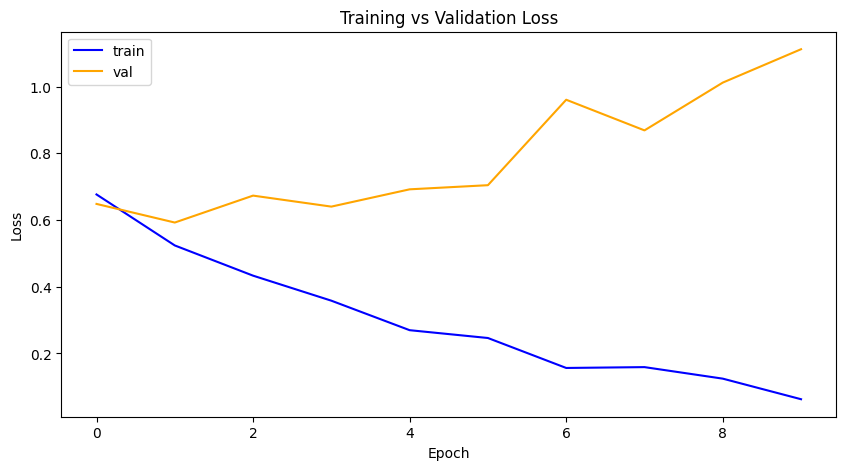

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Acc.: 0.8181 | Macro-F1: 0.6754


In [8]:
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

model = LightningModule.load_from_checkpoint(model_checkpoint_callback.best_model_path, model=model)
model.cuda(0)

y_trues, y_hats = [], []

for (x, y_true) in iter(data_module.test_dataloader()):

    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true)

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

print(f'Acc.: {accuracy_score(y_trues, y_hats):.4f} | Macro-F1: {f1_score(y_trues, y_hats, average="macro"):.4f}')

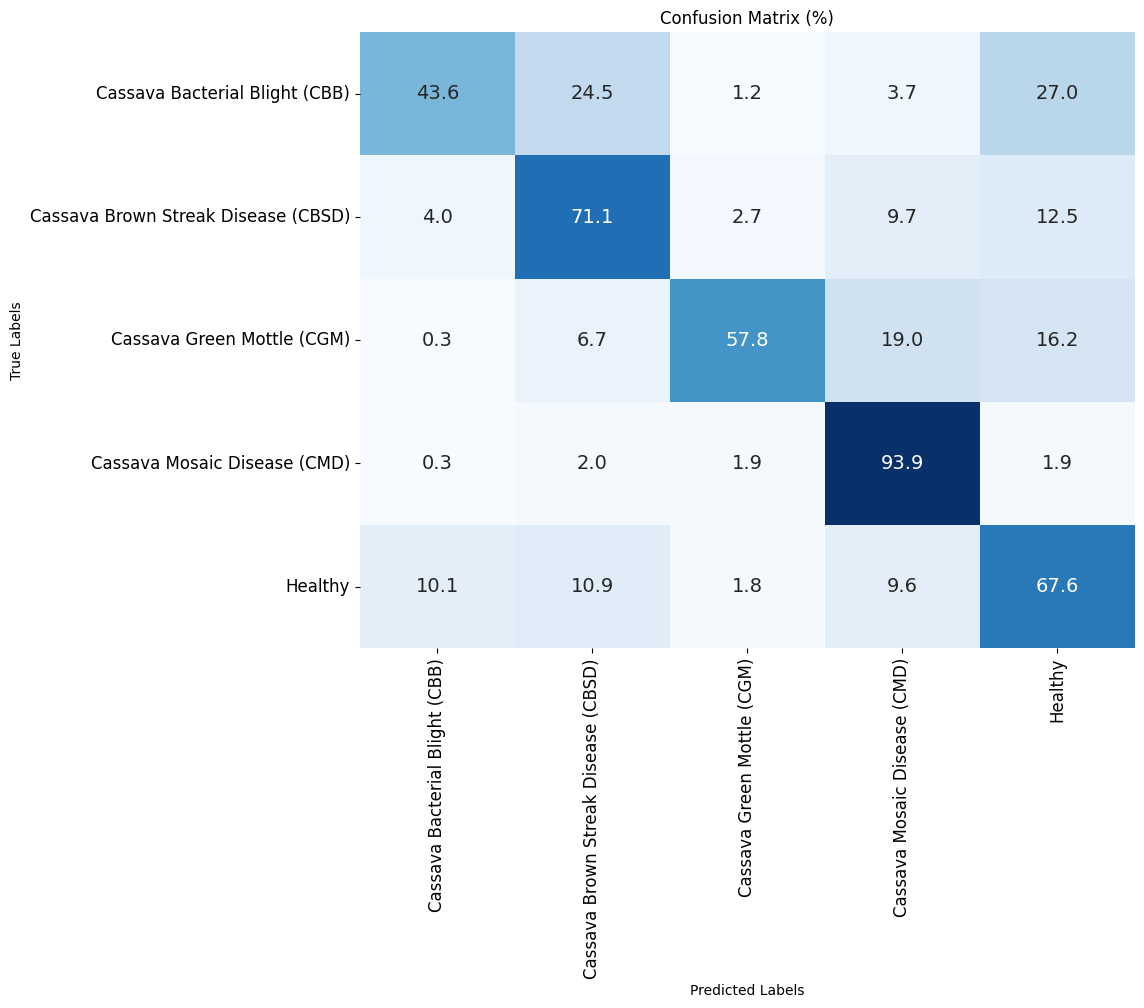

In [15]:
import json
import numpy as np
# Suppose your dataset has 5 classes
with open("cassava/label_num_to_disease_map.json", "r") as f:
            label_map = json.load(f)
            classes = list(label_map.values())

class_labels = classes  # ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']


# Convert class labels to indices for confusion_matrix
labels_idx = list(range(len(class_labels)))  # [0,1,2,3,4]

cm = confusion_matrix(y_trues, y_hats, labels=labels_idx)

# Convert to percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
plt.title("Confusion Matrix (%)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("confusion_matrix1.png", dpi=300, bbox_inches='tight')
plt.show()

In [3]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
import pandas as pd
import json

# --- Short class names ---
short_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']

to_pil = T.ToPILImage()

def display_examples_from_module(data_module, y_trues, y_hats, num_images=5):
    """
    Display correctly classified and misclassified images per class from a LightningDataModule
    """
    # Indices
    correct_idx = (y_trues == y_hats).nonzero(as_tuple=True)[0]
    misclassified_idx = (y_trues != y_hats).nonzero(as_tuple=True)[0]

    dataset = data_module.test_dataloader().dataset

    for class_id, class_name in enumerate(short_names):
        # Filter indices for this class
        correct_class_idx = correct_idx[y_trues[correct_idx] == class_id][:num_images]
        misclassified_class_idx = misclassified_idx[y_trues[misclassified_idx] == class_id][:num_images]

        total_rows = 2
        total_cols = num_images
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(2.5*total_cols, 5))
        fig.suptitle(f"Class: {class_name}\nTop: Correct | Bottom: Misclassified", fontsize=16, y=1.05)

        if total_cols == 1:
            axes = axes.reshape(2,1)

        # Correctly classified
        for i, idx in enumerate(correct_class_idx):
            img, _ = dataset[int(idx)]
            pred_label = y_hats[idx].item()
            axes[0, i].imshow(to_pil(img))
            axes[0, i].set_title(f"Pred: {short_names[pred_label]}", color='green', fontsize=9)
            axes[0, i].axis('off')

        for j in range(len(correct_class_idx), total_cols):
            axes[0,j].axis('off')

        # Misclassified
        for i, idx in enumerate(misclassified_class_idx):
            img, true_label = dataset[int(idx)]
            pred_label = y_hats[idx].item()
            axes[1, i].imshow(to_pil(img))
            axes[1, i].set_title(f"True: {short_names[int(true_label)]}\nPred: {short_names[int(pred_label)]}", color='red', fontsize=9)
            axes[1, i].axis('off')

        for j in range(len(misclassified_class_idx), total_cols):
            axes[1,j].axis('off')

        plt.subplots_adjust(wspace=0.1, hspace=0.25, top=0.8)
        plt.show()

# --- Example usage ---
data_module = CassavaDataModule(df)
data_module.setup(stage='fit')
# y_trues and y_hats obtained from model predictions
display_examples_from_module(data_module, y_trues, y_hats, num_images=5)

NameError: name 'CassavaDataModule' is not defined